## U-Net Implementation

The following is a U-Net implementation for semantic segmentation

#### Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from skimage.transform import resize 
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Dropout, Dense, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


#### Set Parameters

In [2]:
img_width = 128
img_height = 128

In [3]:
list_img = next(os.walk("images"))[2]

In [4]:
# Set X and Y with zeros
chan = 1 #number of channels
X = np.zeros((len(list_img),img_height, img_width, chan), dtype=np.float32)
y = np.zeros((len(list_img),img_height, img_width, chan), dtype=np.float32)
x_size = (img_height, img_width, chan)
print(x_size)

(128, 128, 1)


In [5]:
# Load Image and Mask into array

for n, _id in tqdm(enumerate(list_img), total=len(list_img)):
    img = load_img("images/"+_id, color_mode = 'grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, x_size, mode = 'constant', preserve_range = True)
    
    mask = load_img("masks/"+_id, color_mode = 'grayscale')
    y_img= img_to_array(mask)
    y_img = resize(y_img, x_size, mode = 'constant', preserve_range = True)
    
    X[n] = x_img/255.
    y[n] = y_img/255.
    
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


Text(0.5, 1.0, 'Salt')

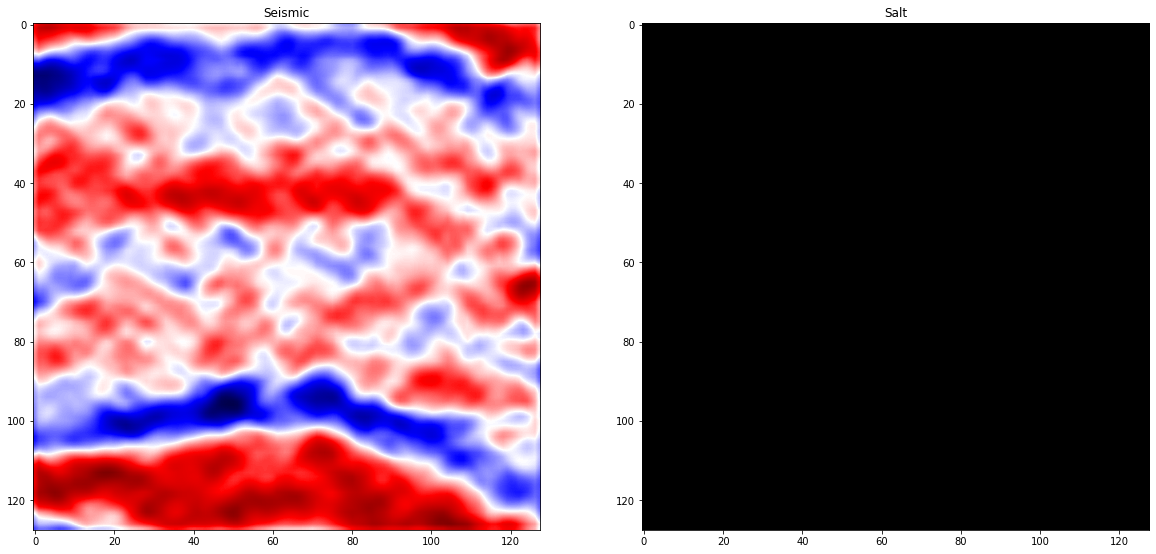

In [6]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

#### Convolutional Block

In [7]:
def conv2d_block(input_tensor,n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(n_filters, (kernel_size,kernel_size),padding='same',\
               kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same',\
               kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

#### U-Net Architecture

In [8]:
def unet(img_input, n_filters=16, dropout=0.1, k_size=3, batchnorm = True):
    c1 = conv2d_block(img_input, n_filters*1, kernel_size=k_size, batchnorm=batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters*2, kernel_size=k_size, batchnorm=batchnorm)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters*4, kernel_size=k_size, batchnorm=batchnorm)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters*8, kernel_size=k_size, batchnorm=batchnorm)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters*16, batchnorm=batchnorm)
    
    
    
    u6 = Conv2DTranspose(n_filters*8, (k_size,k_size), strides = (2,2), padding='same')(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters*8, kernel_size=k_size, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4, (k_size,k_size),strides = (2,2), padding='same')(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters*4, kernel_size=k_size, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2, (k_size,k_size), strides = (2,2), padding='same')(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters*2, kernel_size=k_size, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (k_size,k_size), strides = (2,2), padding='same')(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters*1, kernel_size=k_size, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs= [img_input], outputs= [outputs])
    
    return model
    

#### Config for training

In [10]:
input_img = Input(x_size, name='img')
model = unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [14]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', save_best_only=True,save_weights_only=True, verbose=1)
]

#### Train

In [18]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, verbose=1, callbacks=callbacks,\
          validation_data=(X_valid,y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 127s 35ms/step - loss: 0.3199 - accuracy: 0.8700 - val_loss: 0.8712 - val_accuracy: 0.6079

Epoch 00001: val_loss improved from inf to 0.87125, saving model to model-tgs-salt.h5
Epoch 2/20
3600/3600 [==============================] - 125s 35ms/step - loss: 0.2828 - accuracy: 0.8833 - val_loss: 0.3776 - val_accuracy: 0.8242

Epoch 00002: val_loss improved from 0.87125 to 0.37760, saving model to model-tgs-salt.h5
Epoch 3/20
3600/3600 [==============================] - 125s 35ms/step - loss: 0.2627 - accuracy: 0.8880 - val_loss: 0.3448 - val_accuracy: 0.8590

Epoch 00003: val_loss improved from 0.37760 to 0.34477, saving model to model-tgs-salt.h5
Epoch 4/20
3600/3600 [==============================] - 126s 35ms/step - loss: 0.2453 - accuracy: 0.8956 - val_loss: 0.5065 - val_accuracy: 0.8117

Epoch 00004: val_loss did not improve from 0.34477
Epoch 5/20
3600/3600 [======================

KeyboardInterrupt: 